# Forward pass of Pytorch ConvCaps

## Learned parameters:
1. W : weights
2. beta_v
3. beta_a

**Imports, and set linewidth to 120 characters:**

In [1]:
%load_ext watermark
%matplotlib inline
%watermark

import model.capsules as mcaps

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.distributions import Normal
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

2018-06-14T14:09:10+02:00

CPython 3.6.5
IPython 6.4.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-23-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


## Setup capsules and load learned parameters

In [2]:
class args():
    num_classes = 10
    batch_size = 32
    routing = 'Em_routing'
    loss = 'spread_loss̈́'
    use_recon = 0.0005
    r = 3

A, B, C, D, E, r = 64, 8, 16, 16, args.num_classes, args.r  # a small CapsNet

model = mcaps.CapsNet(args, A, B, C, D, E, r)
model.load_state_dict(torch.load("./weights/em_capsules/model_26.pth"))
model.cuda()

self = model.convcaps1

## Load capsule input (x)

In [3]:
poses = torch.load('poses.pt')
#x = torch.tensor(torch.arange(b*B*4*4*width_in*width_in)).view(b, 4*4*B, width_in, width_in)
print (poses.shape)
print(poses[0,0,:,:])

torch.Size([32, 128, 12, 12])
tensor([[-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771,
         -0.4771, -0.4771, -0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4918,
         -1.8060, -1.9532, -0.3885, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.7517,
         -2.3488, -5.5679, -1.7501, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.0929,
         -3.9795, -9.3959, -0.7119, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.6624, -0.6575,
         -5.4526, -8.6908, -0.4700, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.3410, -3.6315,
         -6.6145, -1.6997, -0.4720, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4837, -0.2908, -4.9080,
         -8.2036, -0.0286, -0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -1.0540, -4.3699, -6.3051,
         

## Load capsule input (activations)

In [4]:
activations = torch.load('activations.pt')     ; print ("activations =", activations.shape)

activations = torch.Size([32, 8, 12, 12])


## Calculate output width

In [5]:
width_in = poses.size(2)
w = int((width_in - self.K) / self.stride + 1) if self.K else 1  ; print ("w =", w)
self.Cww = w * w * self.C                                        ; print ("Cww =", self.Cww)
self.b = poses.size(0)                                           ; print ("batch_size =", self.b)

w = 5
Cww = 400
batch_size = 32


In [6]:
if self.beta_v is None:
    self.beta_v = nn.Parameter(torch.randn(self.C)).cuda()
    self.beta_a = nn.Parameter(torch.randn(self.C)).cuda()

if self.transform_share:
    if self.K == 0:
        self.K = width_in  # class Capsules' kernel = width_in
    W = self.W.view(self.B, 1, 1, self.C, 4, 4).expand(self.B, self.K, self.K, self.C, 4, 4).contiguous()
else:
    W = self.W                                                   ; print ("W =", W.shape) # B,K,K,C,4,4

self.Bkk = self.K * self.K * self.B                              ; print ("Bkk =", self.Bkk)

W = torch.Size([8, 3, 3, 16, 4, 4])
Bkk = 72


## Pose matrix

In [7]:
pose = poses.contiguous()  # b,16*32,12,12
pose = pose.view(self.b, 16, self.B, width_in, width_in).permute(0, 2, 3, 4, 1).contiguous()  # b,B,12,12,16

**Print pose as 12x12 input:**

In [8]:
print (pose.shape)
print (pose[0,0,:,:,0])

torch.Size([32, 8, 12, 12, 16])
tensor([[-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771,
         -0.4771, -0.4771, -0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4918,
         -1.8060, -1.9532, -0.3885, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.7517,
         -2.3488, -5.5679, -1.7501, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.0929,
         -3.9795, -9.3959, -0.7119, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.6624, -0.6575,
         -5.4526, -8.6908, -0.4700, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4771, -0.3410, -3.6315,
         -6.6145, -1.6997, -0.4720, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -0.4837, -0.2908, -4.9080,
         -8.2036, -0.0286, -0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771, -1.0540, -4.3699, -6.3051,
       

**Store every capsule i's poses in each capsule c's receptive field:**

First show some temporary data

In [9]:
tmp = torch.stack([pose[:, :, self.stride*i:self.stride*i+self.K, self.stride*j:self.stride*j+self.K, :]
                   for i in range(w) for j in range(w)])
print (tmp.shape)
print (tmp[0,0,0,:,:,0])
print (tmp[1,0,0,:,:,0])

torch.Size([25, 32, 8, 3, 3, 16])
tensor([[-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771]], device='cuda:0')
tensor([[-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771]], device='cuda:0')


In [10]:
tmp = torch.stack([pose[:, :, self.stride*i:self.stride*i+self.K, self.stride*j:self.stride*j+self.K, :]
                   for i in range(w) for j in range(w)], dim=-1)
print (tmp.shape)
print (tmp[0,0,:,:,0,0])
print (tmp[0,0,:,:,0,1])

torch.Size([32, 8, 3, 3, 16, 25])
tensor([[-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771]], device='cuda:0')
tensor([[-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771]], device='cuda:0')


**Create outputs from convolutions:**

In [11]:
poses = torch.stack([pose[:, :, self.stride * i:self.stride * i + self.K,
                     self.stride * j:self.stride * j + self.K, :] for i in range(w) for j in range(w)],
                    dim=-1)  # b,B,K,K,w*w,16
poses = poses.view(self.b, self.B, self.K, self.K, 1, w, w, 4, 4)  # b,B,K,K,1,w,w,4,4
        
print ("poses =", poses.shape)

poses = torch.Size([32, 8, 3, 3, 1, 5, 5, 4, 4])


**5x5 matrix:**

In [12]:
print (poses.shape)
print (poses[0,0,0,0,0,0,0,:,:])

torch.Size([32, 8, 3, 3, 1, 5, 5, 4, 4])
tensor([[-0.4771, -0.4771, -0.4771, -0.4771],
        [-0.4771, -0.4771, -0.4771, -0.4771],
        [-0.7517, -5.5679, -0.4771, -0.4771],
        [-0.4771, -0.6575, -8.6908, -0.4771]], device='cuda:0')


**W_hat:**

In [13]:
W_hat = W[None, :, :, :, :, None, None, :, :]  # 1,B,K,K,C,1,1,4,4

**Calculate votes:**

In [14]:
votes = W_hat @ poses  # b,B,K,K,C,w,w,4,4

In [15]:
print ("Votes =", votes.shape)
print (votes[0,0,0,0,0,0,0,:,:])

Votes = torch.Size([32, 8, 3, 3, 16, 5, 5, 4, 4])
tensor([[-1.3256, -6.6833, -4.0217, -1.0239],
        [ 0.8400, -1.2612,  5.7206,  0.9657],
        [-0.3835, -5.2845,  8.0420, -0.0939],
        [-0.0995, -3.0810,  6.9854,  0.0792]], device='cuda:0')


## Activation Matrix

In [16]:
print (self.down_w(w=0))
print (self.down_w(w=1))
print (self.down_w(w=2))

range(0, 3)
range(2, 5)
range(4, 7)


**Stack activations to match output size:**

In [17]:
activations_ = [activations[:, :, self.down_w(x), :][:, :, :, self.down_w(y)]
                for x in range(w) for y in range(w)]

print (len(activations_))
print (activations_[0].shape)

25
torch.Size([32, 8, 3, 3])


In [18]:
activation = torch.stack(activations_, dim=4).view(self.b, self.Bkk, 1, -1)
print (activation.shape)
print (activation[0,0,:,:])

torch.Size([32, 72, 1, 25])
tensor([[ 0.1693,  0.1693,  0.1693,  0.1693,  0.1693,  0.1693,  0.1693,
          0.1693,  0.1634,  0.0034,  0.1693,  0.1693,  0.1693,  0.0090,
          0.0370,  0.1693,  0.1693,  0.1699,  0.0005,  0.1907,  0.1693,
          0.1693,  0.0090,  0.0363,  0.1693]], device='cuda:0')


**Again stack activations to match number of capsules:**

In [19]:
activation = activation.repeat(1, 1, self.C, 1)
print (activation.shape)
activation = activation.view(self.b, self.Bkk, self.Cww)
print (activation.shape)

torch.Size([32, 72, 16, 25])
torch.Size([32, 72, 400])


**Format votes:**

In [20]:
votes = votes.view(self.b, self.Bkk, self.Cww, 16)
print ("Votes =", votes.shape)

#votes[0,:,0,0] = torch.tensor([-6,-5.9,-1,-1.02,-1.04,-1.06,-1.08,-1.1,-1.12,-1.14,-1.16,-1.18,2,2.1])

#print (votes[0,:,0,0])

Votes = torch.Size([32, 72, 400, 16])


# EM routing

First we need a function to show graphics:

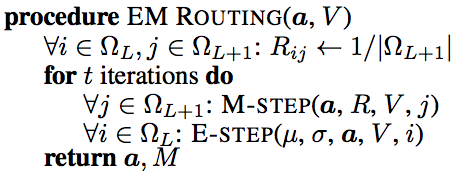

The first line says that this procedure takes all capsules in a lower level L and their outputs (activation_i a and pose vote V_i). The very last line tells you that the algorithm will produce the outputs (activation_j and pose_j) of a higher level capsule. Essentially, this algorithm tells us how to calculate forward pass of the network.

In the second line you will notice that there is a new coefficient R_ij that we haven’t seen before. This coefficient is simply a temporary value that will be iteratively updated and. At start of training the value of R_ij is initialized at 1/(number of capsules in layer L+1).

Line 3 says that the steps in 4–5 will be repeated t times (the number of routing iterations).

Line 4: For all j in layer L+1: Do M-step.
M-step: re-calculate the Gaussian models’ values based on R_ij. The procedure works for one higher-level capsule j.

Line 5: For all i in layer L: Do E-step.
E-step: determines the assignment probability R_ij of each datapoint to a parent capsule. The procedure works for one lower-level capsule i.

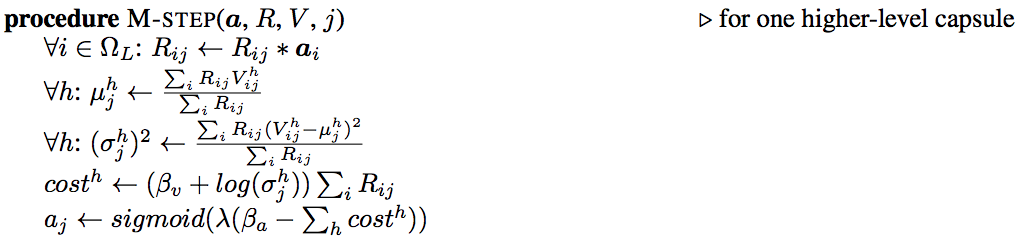

Step in line 2 calculates the value of matrix R_ij which is all routing weights for a lower level capsule i. This is done for multiplying with the activation_i's of all lower level capsules.

The state of all R_ij being equal at initialization of the algorithm represents the state of maximum confusion and uncertainty: lower level capsules have no idea which higher level capsules will best fit their output. Of course, as the process is repeated these uniform distributions will change.

Line 3: For all dimensions h of lover level pose matrices:
Calculate mean mu_h_j for the higher level capsule

Line 4: For all dimensions h of lover level pose matrices:
Calculate sigma^2_h_j for the higher level capsule

line 5: Basically minimizes the sigmas of the gaussians. Beta_v is a learned parameter that learns to minimize sigma.

line 6: Minimizes the summed cost_h from above, and thereby also removes the h dimension. Again Beta_a is a learned bias parameter. Finally, applying a sigmoid, for calculating the activation of the higher-level capsule, j.

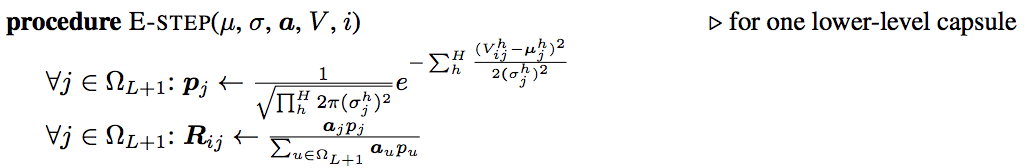

Line 2: Given all mu_h_j and sigma^2_h_j of higher-level capsules, calculated in M-step, calculate the probability density function p_j of the pose votes V_i_j.

Line 3: 

This is where the weight update happens. It is done by adding a softmax to log(a_jxp_j)

In [21]:
def plot2d(data):
    data = [V[i].item() for i in range(len(V))]
        
    new_mus = mu.item()
    new_sigs = sigma_square.item()

    dataX = np.array([R[i].item()*4 for i in range(len(R))])
    
    mind = np.min(data)
    maxd = np.max(data)

    xx = np.linspace(mind-(maxd-mind), maxd+(maxd-mind), 100)
    yy = scs.multivariate_normal.pdf(xx, mean=new_mus, cov=new_sigs)

    colors = sns.color_palette('Dark2', 3)
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.set_ylim(-0.001, np.max(yy))
    ax.plot(xx, yy, color=colors[1])
    ax.axvline(new_mus, ymin=0., color=colors[1])
    ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
    lo, hi = ax.get_ylim()
    
    ax.annotate(f'$\mu_1$: {new_mus:3.2f}',
                fontsize=12, fontweight='demi',
                xy=(new_mus, (hi-lo) / 2), 
                xycoords='data', xytext=((maxd+(maxd-mind))*0.75, (hi-lo) / 2),
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
    
    ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])

    scale = (np.max(yy) / np.max(dataX)) / 2
    dataX = scale * dataX
    
    dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
    ax.plot(data, dataX, 'o', **dot_kwds)
    #ax.plot(data, len(data)*[0], 'o', **dot_kwds)
    plt.show()

def graphics(V, mu, sigma_square, R):
    data = [V[i].item() for i in range(len(V))]
        
    new_mus = mu.item()
    new_sigs = sigma_square.item()

    dataX = np.array([R[i].item()*4 for i in range(len(R))])
    
    mind = np.min(data)
    maxd = np.max(data)

    xx = np.linspace(mind-(maxd-mind), maxd+(maxd-mind), 100)
    yy = scs.multivariate_normal.pdf(xx, mean=new_mus, cov=new_sigs)

    colors = sns.color_palette('Dark2', 3)
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.set_ylim(-0.001, np.max(yy))
    ax.plot(xx, yy, color=colors[1])
    ax.axvline(new_mus, ymin=0., color=colors[1])
    ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
    lo, hi = ax.get_ylim()
    
    ax.annotate(f'$\mu_1$: {new_mus:3.2f}',
                fontsize=12, fontweight='demi',
                xy=(new_mus, (hi-lo) / 2), 
                xycoords='data', xytext=((maxd+(maxd-mind))*0.75, (hi-lo) / 2),
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
    
    ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])

    scale = (np.max(yy) / np.max(dataX)) / 2
    dataX = scale * dataX
    
    dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
    ax.plot(data, dataX, 'o', **dot_kwds)
    #ax.plot(data, len(data)*[0], 'o', **dot_kwds)
    plt.show()

def histogram(a):
    fig, ax = plt.subplots()

    # histogram our data with numpy

    data = [a[i].item() for i in range(a.size(0))]
    n, bins = np.histogram(data, 50)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n


    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    plt.show()

*The pose matrix and the activation of the output capsules are computed iteratively using the EM routing. The EM method fits datapoints into a a mixture of Gaussian models with alternative calls between an E-step and an M-step.*

3 Initialize the assignment probability **$r_{ij}$** to be uniformly distributed. i.e. we start with the children capsules equally related with any parents

12 M-step to compute an updated Gaussian model (μ, σ) and the parent activation **$a_{j}$** from a, V and current **$r_{ij}$**

18 Plot mu,sigma^2 distribution, and plot votes (x-axis) and their routing strength (y-axis).

20 E-step to recompute the assignment probabilities **$r_{ij}$** based on the new Gaussian model and the new **$a_{j}$**.

31 Finally, plot histogram of activation a.

     32, 72, 400, 16
V   :b, Bkk, Cww, 4*4<br>
mu  :(+   -    +    +)<br>
si  :(+   -    +    +)<br>

    :b,   C    w*w  4*4<br>
cost:(+   +    +    +)<br>
a   :(+   +    +)<br>

p   :b, Bkk, Cww, 4*4<br>
ap  :(+   +    +)<br>
R   :(+   +    +)<br>

R is the routing of each pose matrix. That is, there isn't an R for each of the 4x4 elements, but an R for the whole pose matrix.



In [22]:
def EM(self, V):
    # routing coefficient
    R = Variable(torch.ones([self.b, self.Bkk, self.Cww]).view(self.b, self.Bkk, self.Cww), requires_grad=False).cuda() / self.Cww

    for i in range(self.iteration):
        # M-step
        sum_R = R.sum(1)
        mu = ((R[...,None] * V).sum(1) / sum_R[:, :, None])[:, None, :, :]
        sigma_square = ((R[...,None] * (V - mu) ** 2).sum(1) / sum_R[:, :, None])[:, None, :, :]

        X = R[...,None] * V
        X = X.cpu().detach()
        X = X.view(X.shape[0]*X.shape[1]*X.shape[2], -1)
        X = X.numpy()
        print("X.shape",X.shape)
        X_embedded = TSNE(n_components=2).fit_transform(X)
        print("X_embedded.shape",X_embedded.shape)
        plt.scatter(X_embedded[:,0], X_embedded[:,1])#, s=area, c=colors, alpha=0.5)
        plt.show()
        
        # E-step
        if i != self.iteration - 1:
            mu, sigma_square, V_ = mu.data, sigma_square.data, V.data
            normal = Normal(mu, self.eps + sigma_square ** (1 / 2))
            p = torch.exp(normal.log_prob(V_+self.eps))
            p = p.sum(-1)
            R = Variable(p / torch.sum(p, -1)[..., None], requires_grad=False) + self.eps

    return mu

def EM_routing(self, lambda_, a_, V):
    # routing coefficient
    R = Variable(torch.ones([self.b, self.Bkk, self.Cww]).view(self.b, self.Bkk, self.Cww), requires_grad=False).cuda() / self.Cww

    for i in range(self.iteration):
        # M-step
        R = (R * a_)[..., None]
        sum_R = R.sum(1)
        mu = ((R[..., None] * V).sum(1) / sum_R)[:, None, :, :]
        sigma_square = (R * (V - mu) ** 2).sum(1) / sum_R

        
        print("R.shape",R.shape)
        print("(R * V).shape", (R * V).shape)
        X = (R * V) - mu
        X = X.cpu().detach()
        X = X.view(X.shape[0]*X.shape[1]*X.shape[2], -1)
        X = X.numpy()
        print("X.shape",X.shape)
        X_embedded = TSNE(n_components=2).fit_transform(X)
        print("X_embedded.shape",X_embedded.shape)
        plt.scatter(X_embedded[:,0], X_embedded[:,1])#, s=area, c=colors, alpha=0.5)
        plt.show()
        
        
        #graphics(V[0,:,0,0], mu[0,:,0,0], sigma_square[0,0,0], R[0,:,0,0])
        
        cost = (self.beta_v.view(1,self.C,1,1) + torch.log(sigma_square.sqrt().view(self.b,self.C,-1,16)+self.eps)) * sum_R.view(self.b, self.C,-1,1)
        a = torch.sigmoid(lambda_ * (self.beta_a.view(1,self.C,1) - cost.sum(-1)))
        a = a.view(self.b, self.Cww)
        
        # E-step
        if i != self.iteration - 1:
            mu, sigma_square, V_, a__ = mu.data, sigma_square.data, V.data, a.data
            normal = Normal(mu, self.eps + sigma_square[:, None, :, :] ** (1 / 2))
            p = torch.exp(normal.log_prob(V_+self.eps))
            print("V.shape", V.shape)
            print("mu.shape",mu.shape)
            print("sig.shape",sigma_square.shape)
            print("p.shape:",p.shape)
            print("pSum.shape:",p.sum(-1).shape)
            print("a__.shape:",a__.shape)
            ap = a__[:,None,:] * p.sum(-1)
            print("ap.shape",ap.shape)
            R = Variable(ap / torch.sum(ap, -1)[..., None], requires_grad=False) + self.eps
            print("R.shape",R.shape)
            print()

    return a, mu

In [30]:
def em_gmm_orig(self, xs, max_iter=10):

    pis = torch.tensor( np.random.random(2) )
    pis /= pis.sum()
    mus = torch.tensor( np.random.random((2,2)) )
    sigmas = torch.tensor([np.eye(2)] * 2) * 100 #height.std()
    
    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = pis[j] * Normal(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)
        print("ws",ws)

        # M-step
        pis = ws.sum(axis=1)
        pis /= n
        print("pis",pis)

        #mus = np.dot(ws, xs)
        mus = ws @ xs
        mus /= ws.sum(1)[:, None]
        print("mus",mus)

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = xs - mus[j, :]
            sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:,None,None]
        print("sigmas",sigmas)
        
    return mus

In [31]:
self.b = 1
self.C = 2
self.B = 4
#self.K = 1
self.Bkk = self.B*self.K*self.K
#w = 1
self.Cww = self.C*w*w
self.iteration = 15
lambda_ = 0.9
#self.beta_v = nn.Parameter(torch.randn(self.C).cuda())
#self.beta_a = nn.Parameter(torch.randn(self.C).cuda())
self.beta_v = torch.nn.Parameter(self.beta_v[0:self.C])
self.beta_a = torch.nn.Parameter(self.beta_a[0:self.C])
activation_test = activation[0:self.b,0:self.Bkk,0:self.Cww].view(self.b, self.Bkk, self.Cww)
#votes_test = votes[0:self.b,0:self.Bkk,0:self.Cww,:].view(self.b, self.Bkk, self.Cww, 16)
votes_test = votes[0,0,0:self.Cww,:].view(self.Cww, 16)

poses = em_gmm_orig(self, votes_test)
#activations, poses = EM_routing(self, lambda_, activation_test, votes_test)

AttributeError: 'Normal' object has no attribute 'pdf'

$$\mu^h_j = \dfrac{\sum_i r_{ij} V^h_{ij}}{\sum_i r_{ij}}$$
$$(\sigma^h_j)^2 = \dfrac{\sum_i r_{ij} (V^h_{ij} - mu^h_j)^2}{\sum_i r_{ij}}$$
$$cost_h = (\beta_u + log \sigma^h_j) * \sum_i r_{ij}$$
$$a_j = logistic(\lambda * (\beta_a - \sum_h cost_h))$$